In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df=pd.read_csv("Walmart.csv")

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df["Year"] = df["Date"].str[-4:]
df["Month"] = df["Date"].str[3:5]
df["Day"] = df["Date"].str[0:2]

In [5]:
df["date"]=pd.to_datetime(df["Year"].astype(str)+"--"+df["Month"].astype(str)+"--"+df["Day"])

In [6]:
df.drop("Date",axis=1,inplace=True)

In [7]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,date
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,02,05,2010-02-05
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,02,12,2010-02-12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,02,19,2010-02-19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,02,26,2010-02-26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,03,05,2010-03-05


In [8]:

def analyze_static(store_id, df, diffs=3):
    num=0
    stored_data = df[df["Store"] == store_id]
    result = adfuller(stored_data["Weekly_Sales"])
    print(f"P-value is {result[1]}")
    if result[1] < 0.05:
        print("The data is stationary")
        d = 0  
        D=0
        diffed_sales = stored_data["Weekly_Sales"]  
    else:
        print("Differencing needed")
        d = num 
        D = num

        while result[1] > 0.05 and num < diffs:
            diffed_sales = stored_data["Weekly_Sales"].diff()
            diffed_sales.dropna(inplace=True)
            result = adfuller(diffed_sales)
            num += 1
            print(f"The number of differencing is {num}")
            
            
    plot_acf(diffed_sales)
    plot_pacf(diffed_sales)
    plt.show()
        
    return diffed_sales, d, D

P-value is 1.3877788330759535e-05
The data is stationary


C:\Users\samad\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


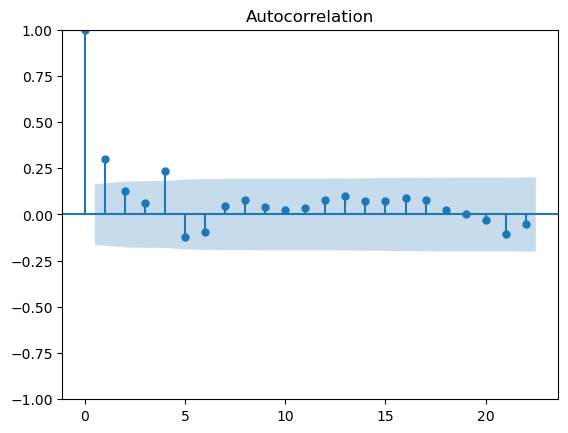

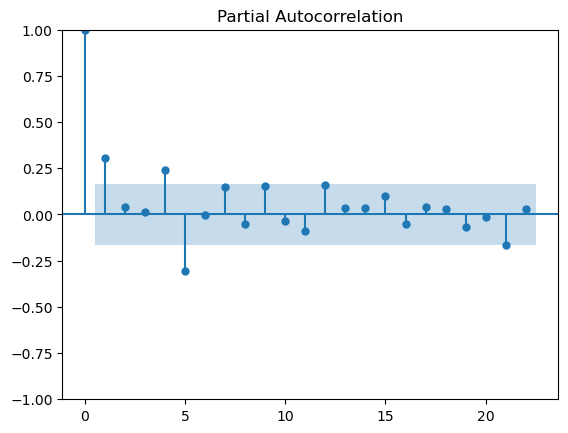

(0      1643690.90
 1      1641957.44
 2      1611968.17
 3      1409727.59
 4      1554806.68
           ...    
 138    1437059.26
 139    1670785.97
 140    1573072.81
 141    1508068.77
 142    1493659.74
 Name: Weekly_Sales, Length: 143, dtype: float64,
 0,
 0)

In [9]:
store_id=1
analyze_static(store_id,df)

In [10]:
def analyze_store(store_id, df, p=5, q=4, P=5, Q=4, S=52):
    stored_data = df[df["Store"] == store_id]
    diffed_sales, d,D = analyze_static(store_id, df, diffs=3)  
    
    train_size = int(0.8 * len(diffed_sales))
    train_data = diffed_sales[:train_size]
    test_data = diffed_sales[train_size:]
    
    model_holt = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=S,trend="add")
    model_holt_fit = model_holt.fit()
    predict_hw = model_holt_fit.forecast(len(test_data))
    
    mse_hw = mean_squared_error(test_data, predict_hw)
    rmse_hw = mse_hw ** 0.5
    print(f"The MSE for Holt Winter for {store_id}: {mse_hw}")
    print(f"The RMSE for Holt Winter for {store_id}: {rmse_hw}")
    

    
    # Perform SARIMA modeling
    model_sarimax = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_sarimax_fit = model_sarimax.fit()
    pred_sarimax = model_sarimax_fit.forecast(len(test_data))
    
    mse_sarimax = mean_squared_error(test_data, pred_sarimax)
    rmse_sarimax = mse_sarimax ** 0.5
    print(f"The MSE for SARIMA for {store_id}: {mse_sarimax}")
    print(f"The RMSE for SARIMA for {store_id}: {rmse_sarimax}")

P-value is 1.3877788330759535e-05
The data is stationary


C:\Users\samad\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


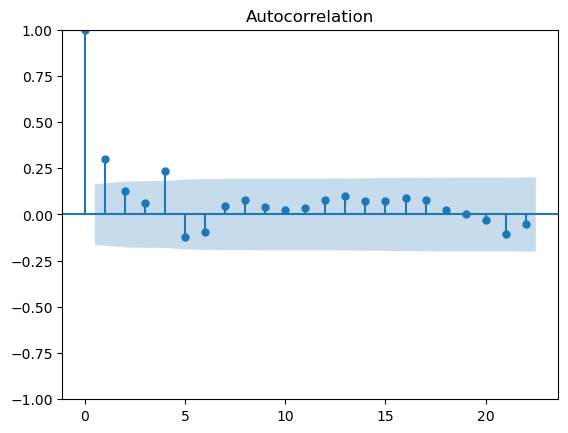

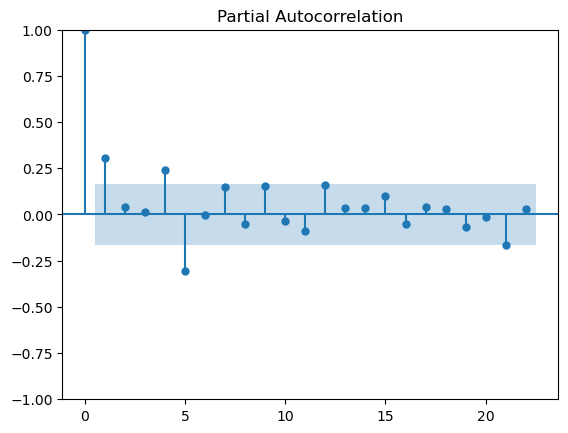

C:\Users\samad\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\samad\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\samad\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\samad\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


The MSE for Holt Winter for 1: 5648063440.70742
The RMSE for Holt Winter for 1: 75153.5989870573


C:\Users\samad\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The MSE for SARIMA for 1: 5186982490.018119
The RMSE for SARIMA for 1: 72020.70875809345


In [11]:
store_id=1
analyze_store(store_id,df)